# Effects of average temperatures and temperature variability 
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats

Data locations

In [2]:
loc_panel = "../Data/Panel/"
loc_regression = "../Data/RegressionResults/"
loc_shp = "../Data/Shapefile/"

#### Analysis

Read shapefile

In [3]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
shp = shp.rename(columns={"GID_1":"region"})

Read panel

In [4]:
edd_type = "month"
extr = "tx5d"
panel = pd.read_csv(loc_panel+"extremes_growth_panel_"+edd_type+"edd_1979-2016.csv",index_col=0)

Plot t vs tx5d and then remove region means and plot

In [5]:
panel_plot = panel.loc[:,["region","time","t","tx5d"]]
panel_mean = panel_plot.groupby(["region"]).mean().reset_index().loc[:,["region","t","tx5d"]]
panel_plot = pd.merge(panel_plot,panel_mean.rename(columns={"t":"t_mean","tx5d":"tx5d_mean"}),how="left",on="region")
panel_plot["t_deviation"] = panel_plot.t.values - panel_plot.t_mean.values
panel_plot["tx5d_deviation"] = panel_plot.tx5d.values - panel_plot.tx5d_mean.values

In [6]:
np.nanstd(panel.loc[panel.t!=0,:].t.values)

8.172499214364342

In [7]:
np.nanmean(panel.loc[panel.t!=0,["region","t"]].groupby("region").std().reset_index().t.values)

0.578520321933734

Plot two panels

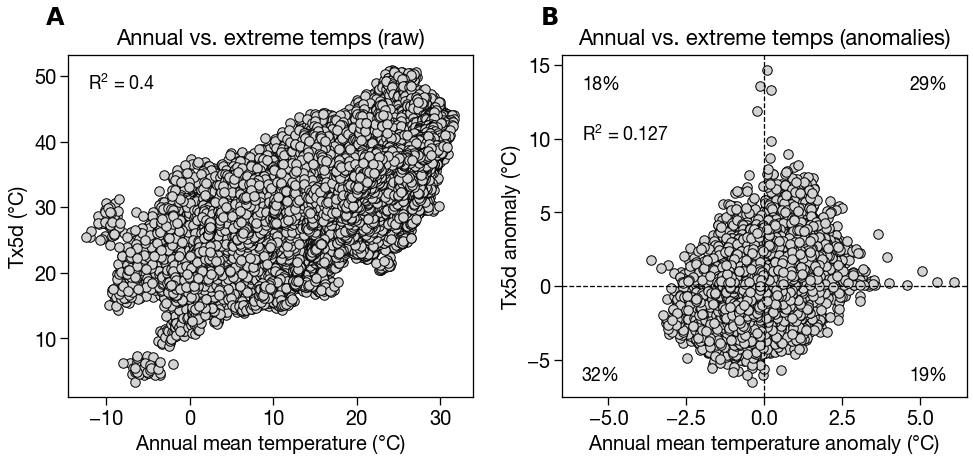

In [8]:
fig = plt.figure(figsize=(16,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.15,right=0.93,top=0.85,bottom=0.17,wspace=0.22,hspace=0.3)

for j in [0,1]:
    ax = plt.subplot(gs1[0,j])
    
    panel_plot1 = panel_plot.loc[(panel_plot.t.values!=0),:]
    
    if j == 0:
        x = panel_plot1.t.values
        y = panel_plot1.tx5d.values
    else:
        x = panel_plot1.t_deviation.values
        y = panel_plot1.tx5d_deviation.values
        
    ind = (~np.isnan(x))&(~np.isnan(y))
    x1 = x[ind]
    y1 = y[ind]
    
    slope, intercept, r, p, se = stats.linregress(x1,y1)
    r2 = np.around(r**2,3)
    plt.scatter(x1,y1,s=90,facecolor="lightgray",edgecolor="black")
    
    if j == 0:
        plt.xlabel("Annual mean temperature ($\degree$C)")
        plt.ylabel("Tx5d ($\degree$C)")
        plt.title("Annual vs. extreme temps (raw)",fontsize=22,pad=10)
        plt.text(0.05,0.9,"R$^2$ = "+str(r2),fontsize=18,transform=ax.transAxes)
    else:
        plt.xlabel("Annual mean temperature anomaly ($\degree$C)")
        plt.ylabel("Tx5d anomaly ($\degree$C)")
        plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")
        plt.axvline(x=0,linewidth=1.3,color="black",linestyle="--")
        plt.title("Annual vs. extreme temps (anomalies)",fontsize=22,pad=10)
        plt.text(0.05,0.75,"R$^2$ = "+str(r2),fontsize=18,transform=ax.transAxes)
        n_pos_pos = int(100*len(x1[(x1>0)&(y1>0)])/len(x1))
        n_pos_neg = int(100*len(x1[(x1>0)&(y1<0)])/len(x1))
        n_neg_pos = int(100*len(x1[(x1<0)&(y1>0)])/len(x1))
        n_neg_neg = int(100*len(x1[(x1<0)&(y1<0)])/len(x1))
        plt.text(0.86,0.9,str(n_pos_pos)+"%",fontsize=18,transform=ax.transAxes)
        plt.text(0.86,0.05,str(n_pos_neg)+"%",fontsize=18,transform=ax.transAxes)
        plt.text(0.05,0.05,str(n_neg_neg)+"%",fontsize=18,transform=ax.transAxes)
        plt.text(0.05,0.9,str(n_neg_pos)+"%",fontsize=18,transform=ax.transAxes)
        plt.xlim([-6.5,6.5])
    
    
    
plt.figtext(0.13,0.91,r'$\bf{A}$',fontsize=24)
plt.figtext(0.56,0.91,r'$\bf{B}$',fontsize=24)

plt.savefig("../Figures/SciAdv_Revision1/FigX_T_vs_Tx5d.png")    
plt.show()

Regress t on tx in each region separately

In [9]:
regions_uq = np.unique(panel.region.values)
t_tx_coefs = xr.DataArray(np.full(len(regions_uq),np.nan),coords=[regions_uq],dims=["region_uq"])
t_tx_r2 = xr.DataArray(np.full(len(regions_uq),np.nan),coords=[regions_uq],dims=["region_uq"])

In [10]:
for r in regions_uq:
    t_r = panel.loc[panel.region.values==r,"t"].values
    tx_r = panel.loc[panel.region.values==r,extr].values
    if (np.all(~np.isnan(t_r)))&(np.all(~np.isnan(tx_r))):
        beta, intr, rval, p, se = stats.linregress(t_r,tx_r)
        t_tx_coefs.loc[r] = beta
        t_tx_r2.loc[r] = rval**2
        if rval>0.9:
            print(r)
            print(t_r)
            print(tx_r)

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Plot R-squared

In [11]:
x = t_tx_r2[~np.isnan(t_tx_r2)]

Now plot effects of extremes, average temperatures, and variability all together

In [12]:
tx_scaling = 100*np.nanmean(panel.groupby("region").std()[extr].values)
var_scaling = 100*np.nanmean(panel.groupby("region").std()["var"].values)
t_scaling = 100*np.nanmean(panel.groupby("region").std()["t"].values)

In [13]:
t_ex = np.arange(-5,35+1,1)
tx_ex = np.arange(10,50+1,1)

for each value in t_ex, calculate the average tx5d found in its bin

In [14]:
tx_t = np.zeros(len(t_ex))
for tt in np.arange(0,len(tx_t),1):
    t1 = t_ex[tt]-1
    t2 = t_ex[tt]+1
    tx_t[tt] = np.nanmean(panel.loc[(panel.t>=t1)&(panel.t<t2),"tx5d"].values)

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


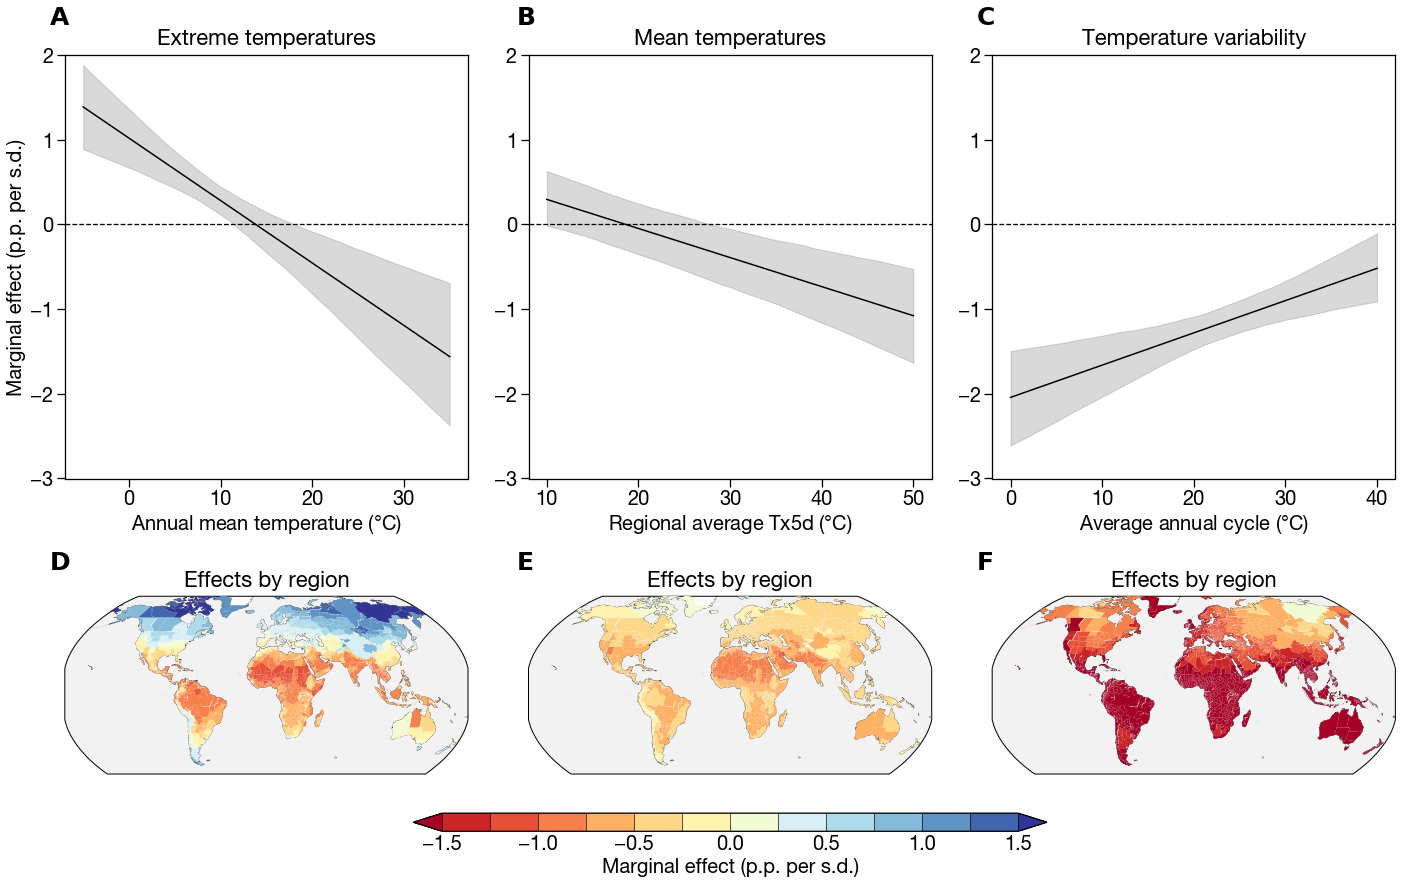

In [15]:
fig = plt.figure(figsize=(22,14))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.12,right=0.96,top=0.89,bottom=0.47,wspace=0.15,hspace=0.3)

gs2 = gridspec.GridSpec(1,3)
gs2.update(left=0.12,right=0.96,top=0.43,bottom=0.1,wspace=0.15,hspace=0.3)


seas_ex = np.arange(0,40+1,1)

for k in [0,1,2]:
    ax = plt.subplot(gs1[0,k])
    
    if k == 0:
        coefs_in = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_contemporaneous.csv",index_col=0)
        coefs_main = coefs_in.coef_main.values
        coefs_interact = coefs_in.coef_interact.values
        x = t_ex
        scal = tx_scaling
    elif k == 1:
        coefs_in = pd.read_csv(loc_regression+"temperature_coefs_"+extr+"_model_bootstrap_contemporaneous.csv",index_col=0)
        coefs_main = coefs_in.coef_t.values
        coefs_interact = coefs_in.coef_t2.values
        coefs_interact2 = pd.read_csv(loc_regression+extr+"_coefs_bootstrap_contemporaneous.csv",index_col=0).coef_interact.values
        x = tx_ex
        scal = t_scaling
    elif k == 2:
        coefs_in = pd.read_csv(loc_regression+"variability_coefs_"+extr+"_model_bootstrap_contemporaneous.csv",index_col=0)
        coefs_main = coefs_in.coef_var.values
        coefs_interact = coefs_in.coef_interact.values
        x = seas_ex
        scal = var_scaling
    
    if k in [0,2]:
        nboot = len(coefs_in.boot.values)
        me_matrix = np.zeros((len(x),nboot))
        for n in np.arange(0,nboot,1):
            me_matrix[:,n] = scal*(coefs_main[n] + coefs_interact[n]*x)
        
        ame = np.mean(me_matrix,axis=1)
        ci_upper = np.percentile(me_matrix,97.5,axis=1)
        ci_lower = np.percentile(me_matrix,2.5,axis=1)

        plt.plot(x,ame,color="black",linewidth=1.5)
        ax.fill_between(x,ci_lower,ci_upper,
                       color="black",alpha=0.15)
    else:
        nboot = len(coefs_in.boot.values)
        me_matrix = np.zeros((len(x),nboot))
        for n in np.arange(0,nboot,1):
            me_matrix[:,n] = scal*(coefs_main[n] + coefs_interact2[n]*tx_ex) 
                            #scal*(coefs_main[n] + 2*coefs_interact[n]*x + coefs_interact2[n]*tx_t)
        ame = np.mean(me_matrix,axis=1)
        ci_upper = np.percentile(me_matrix,97.5,axis=1)
        ci_lower = np.percentile(me_matrix,2.5,axis=1)

        plt.plot(x,ame,color="black",linewidth=1.5)
        ax.fill_between(x,ci_lower,ci_upper,
                           color="black",alpha=0.15)
    
    plt.ylim([-3,2])
    #plt.yticks([-3,-2,-1,0,1])
    plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")
    
    if k == 0:
        plt.ylabel("Marginal effect (p.p. per s.d.)")
    
    lfs = 18
    tfs = 22
    if k == 0:
        plt.xlabel("Annual mean temperature ($\degree$C)")
        plt.title("Extreme temperatures",pad=10,fontsize=tfs)
    elif k == 1:
        plt.xlabel("Regional average Tx5d ($\degree$C)")
        plt.title("Mean temperatures",pad=10,fontsize=tfs)
    elif k == 2:
        plt.xlabel("Average annual cycle ($\degree$C)")
        plt.title("Temperature variability",pad=10,fontsize=tfs)

    # maps! will take a while...
    ax = plt.subplot(gs2[0,k],projection=ccrs.Robinson())
    ax.set_extent([-180,180,-63,80],crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.95,0.95,0.95])
    ax.add_feature(cart.feature.LAND, edgecolor="white",facecolor=[0.98,0.98,0.98])
    
    # set colors
    vmin = -1.5
    vmax = 1.5
    ncol = 13 # choose a number greater than
                  # the number of colors you actually want
    bounds = np.linspace(vmin,vmax,ncol)
    cmapname = 'RdYlBu'
    cols = plt.get_cmap(cmapname)(np.linspace(0,1,len(bounds)+1))
    cm = colors.ListedColormap(cols[1:-1])
    cm.set_over(cols[-1])
    cm.set_under(cols[0])
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
    
    if k == 0:
        coefs_main_mean = np.nanmean(coefs_main)
        coefs_interact_mean = np.nanmean(coefs_interact)
    elif k == 1:
        coefs_main_mean = np.nanmean(coefs_main)
        coefs_interact_mean = np.nanmean(coefs_interact)
        coefs_interact2_mean = np.nanmean(coefs_interact2)
    elif k == 2:
        coefs_main_mean = np.nanmean(coefs_main)
        coefs_interact_mean = np.nanmean(coefs_interact)
            
    # add geometries
    
    import warnings
    warnings.filterwarnings("ignore",category=RuntimeWarning,message="Mean of empty")
    for i in shp.region.values:
        geom = shp.loc[shp.region==i,"geometry"]
        if k == 0:
            val1 = np.nanmean(panel.loc[panel.region==i,"t"])
            val = scal*(coefs_main_mean + coefs_interact_mean*val1)
        elif k == 1:
            val1 = np.nanmean(panel.loc[panel.region==i,"t"].values)
            val2 = np.nanmean(panel.loc[panel.region==i,"tx5d"].values)
            #val = scal*(coefs_main_mean + coefs_interact_mean*val1 + coefs_interact2_mean*val2)
            val = scal*(coefs_main_mean + coefs_interact2_mean*val2)
        elif k == 2:
            val1 = np.nanmean(panel.loc[panel.region==i,"seas"].values)
            val = scal*(coefs_main_mean + coefs_interact_mean*val1)
        if np.nanmean(panel.loc[panel.region==i,"t"].values)==0:
            # if t is exactly zero it's an error
            val = np.nan
        
        
        col = cbar.to_rgba(val)
        if  (~np.isnan(val)):
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                     edgecolor="black",linewidth=0,zorder=10)
        elif np.isnan(val):
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=[0.98,0.98,0.98],
                                     edgecolor="black",linewidth=0)
        
    
    
    plt.title("Effects by region",pad=10,fontsize=tfs)
    
    if k == 2:
        cbar_ax = fig.add_axes([0.34,0.12,0.4,0.018])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                          drawedges=True,extend="both")
        cbar_ax.tick_params(direction="in",width=0.05)
        cb.set_label("Marginal effect (p.p. per s.d.)")
    
plt.figtext(0.11,0.92,r"$\bf{A}$",fontsize=25)
plt.figtext(0.405,0.92,r"$\bf{B}$",fontsize=25)
plt.figtext(0.695,0.92,r"$\bf{C}$",fontsize=25)

plt.figtext(0.11,0.38,r"$\bf{D}$",fontsize=25)
plt.figtext(0.405,0.38,r"$\bf{E}$",fontsize=25)
plt.figtext(0.695,0.38,r"$\bf{F}$",fontsize=25)

plt.savefig("../Figures/All_Marginal_Effects.png")
plt.show()